# Part 3 - Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long-term rider retention (again, a few sentences will suffice).

## Data description
- `city`: city this user signed up in
- `phone`: primary device for this user
- `signup_date`: date of account registration; in the form ‘YYYYMMDD’
- `last_trip_date`: the last time this user completed a trip; in the form ‘YYYYMMDD’
- `avg_dist`: the average distance in miles per trip taken in the first 30 days after signup
- `avg_rating_by_driver`: the rider’s average rating over all of their trips
- `avg_rating_of_driver`: the rider’s average rating of their drivers over all of their trips
- `surge_pct`: the percent of trips taken with surge multiplier > 1
- `avg_surge`: The average surge multiplier over all of this user’s trips
- `trips_in_first_30_days`: the number of trips this user took in the first 30 days after signing up
- `ultimate_black_user`: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
- `weekday_pct`: the percent of the user’s trips occurring during a weekday

# _Set Up_

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import libraries
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import random
import os
from pathlib import Path

# Matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [3]:
path = os.getcwd()
path + '/data/ultimate_data_challenge.json'

'/Users/jai/Documents/Springboard-DS-Portfolio/unit17-take-home-challenges/ultimate_technologies/data/ultimate_data_challenge.json'

# _Load Data_

In [6]:
from ultimate_challenge import predict

df = predict.load_data(path)
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [8]:
df.isnull().sum()

avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
city                         0
last_trip_date               0
phone                      396
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
ultimate_black_user          0
weekday_pct                  0
dtype: int64

# _Observations_ 

Looks like we have some missing values in the `avg_rating_by_driver`, `avg_rating_of_driver` and `phone` columns. Additionally there are two columns - `last_trip_date` and `signup_date` - that are currently set to object data types when they would be more useful in a datetime format. 

So let's change those columns to datetime then dive a little further into the columns with missing values to figure out the best approach.

In [9]:
# change last_trip_date and signup_date 
df[['last_trip_date', 'signup_date']] = df[['last_trip_date', 'signup_date']].apply(pd.to_datetime)
df[['last_trip_date', 'signup_date']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
last_trip_date    50000 non-null datetime64[ns]
signup_date       50000 non-null datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 781.3 KB


The mean for the avg_rating_by_driver column is equal to 4.778158195947439
------------------------------
The mean for the avg_rating_of_driver column is equal to 4.6015592912744685
------------------------------


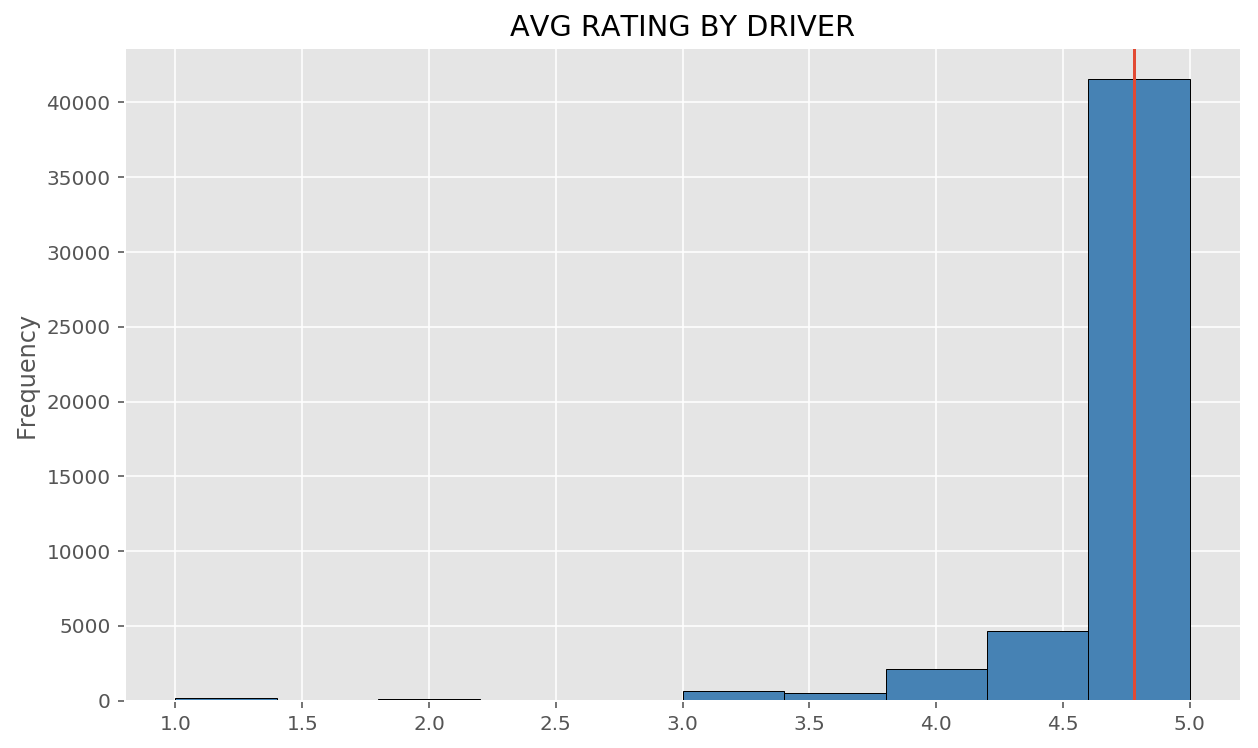

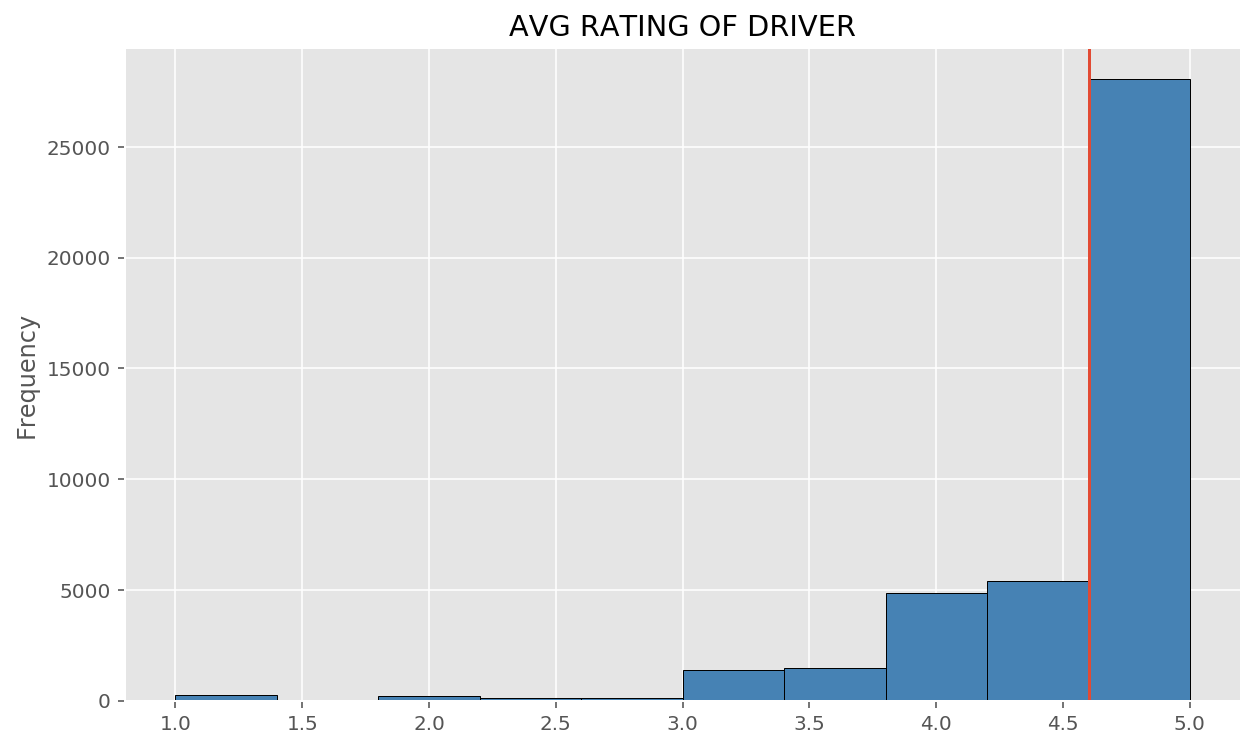

In [10]:
# generate histogram 
predict.multi_hist_plot(df, ['avg_rating_by_driver', 'avg_rating_of_driver'])

# _Observations_

The ratings by the driver and of the driver are both highly skewed. In order to preserve this distribution (as it is pretty significant) how should we address the missing values in `avg_rating_by_driver` & `avg_rating_of_driver`? A simple yet effective strategy is replacing these missing values with the mean, which is was we'll do next.

In [11]:
df['avg_rating_by_driver'].fillna(np.mean(df['avg_rating_by_driver']), inplace=True)
df['avg_rating_of_driver'].fillna(np.mean(df['avg_rating_of_driver']), inplace=True)

In [12]:
df[['avg_rating_by_driver', 'avg_rating_of_driver']].isnull().sum()

avg_rating_by_driver    0
avg_rating_of_driver    0
dtype: int64

In [13]:
# double check to see if there are any other columns with missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


# _Observations_

It looks like we have one last column that has missing values - `phone`. Before we can start to analyze it though, we have to convert it from a object data type to a categorical one. 

In [14]:
df['phone'] = df['phone'].astype('category')
df['phone'].dtype

CategoricalDtype(categories=['Android', 'iPhone'], ordered=False)

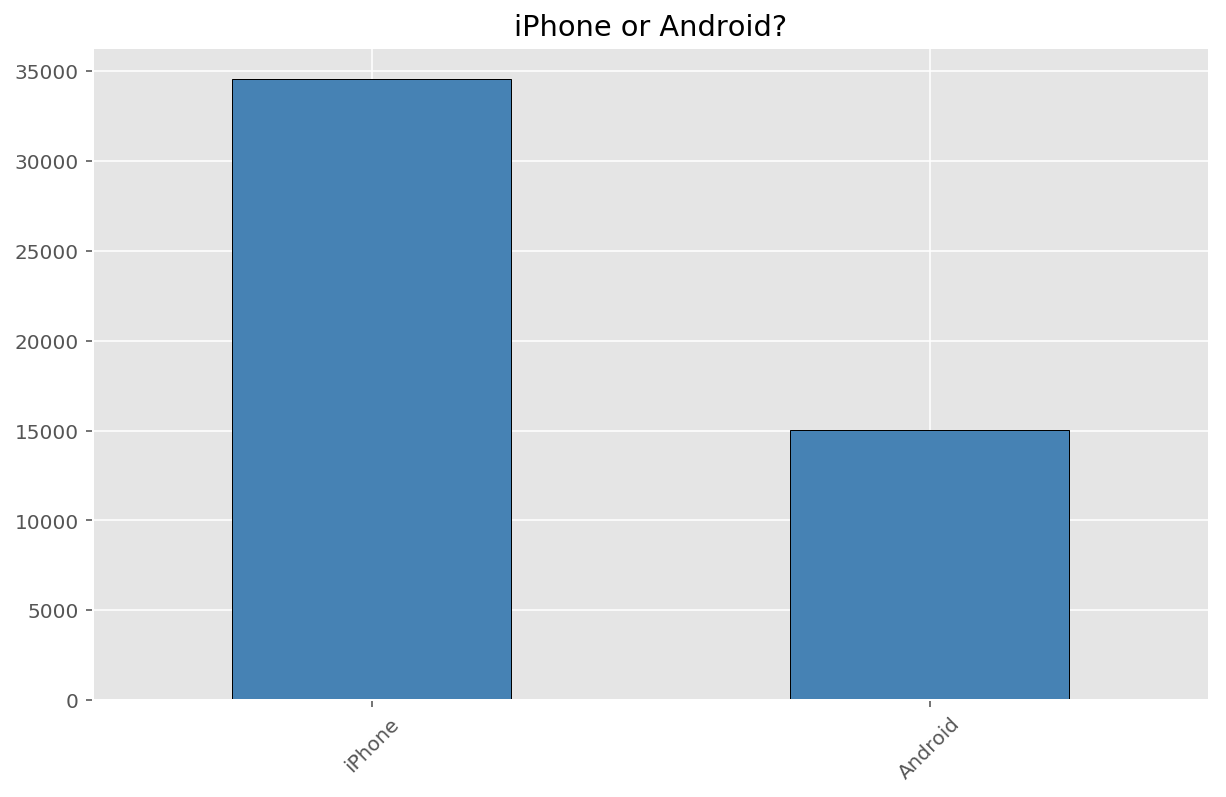

In [15]:
predict.value_counts_plot(df, 'phone', 'iPhone or Android?')

In [16]:
df['phone'].value_counts(normalize=True, dropna=False)

iPhone     0.69164
Android    0.30044
NaN        0.00792
Name: phone, dtype: float64

# _Observations_

As we can see above, it looks to be a 70/30 split approximately in favor of the iPhone. Because this column is a categorical data type, we can't use the mean like we did before. 

What we'll do instead is randomly choose either `iPhone` or `Android` according to their probabilities (i.e. 0.69 or 0.31) and assign that value into missing observations. 

In [17]:
df['phone'] = df['phone'].fillna(np.random.choice(['iPhone', 'Android'], p = [0.69, 0.31]))

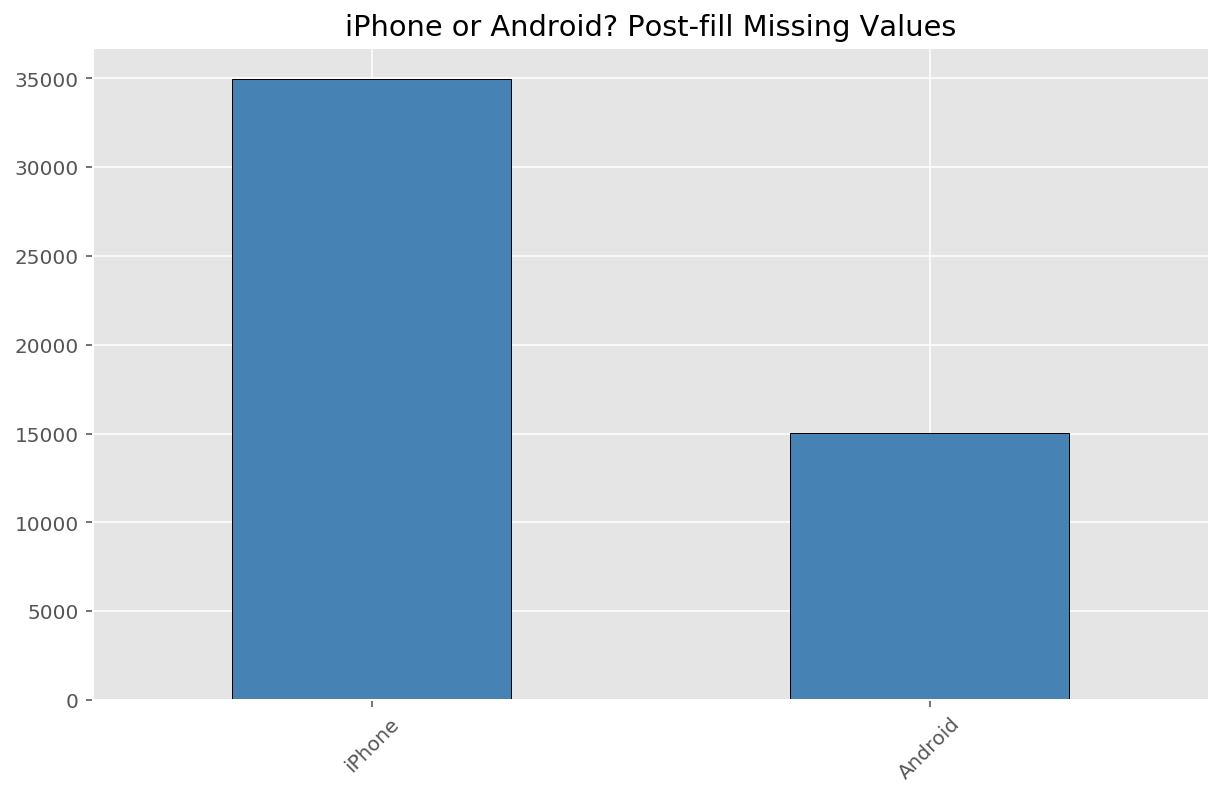

In [18]:
predict.value_counts_plot(df, 'phone', 'iPhone or Android? Post-fill Missing Values')

In [19]:
df['phone'].value_counts(normalize=True, dropna=False)

iPhone     0.69956
Android    0.30044
Name: phone, dtype: float64

In [20]:
# change city to category type
df['city'] = df['city'].astype('category')

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null category
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null category
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), category(2), datetime64[ns](2), float64(6), int64(1)
memory usage: 3.6 MB


# _Observations_

No more missing values! Looks like we can dive a little bit deeper and do some EDA on the columns to get a better picture of their respective distributions.

In [22]:
number_cols = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'trips_in_first_30_days',
              'weekday_pct']

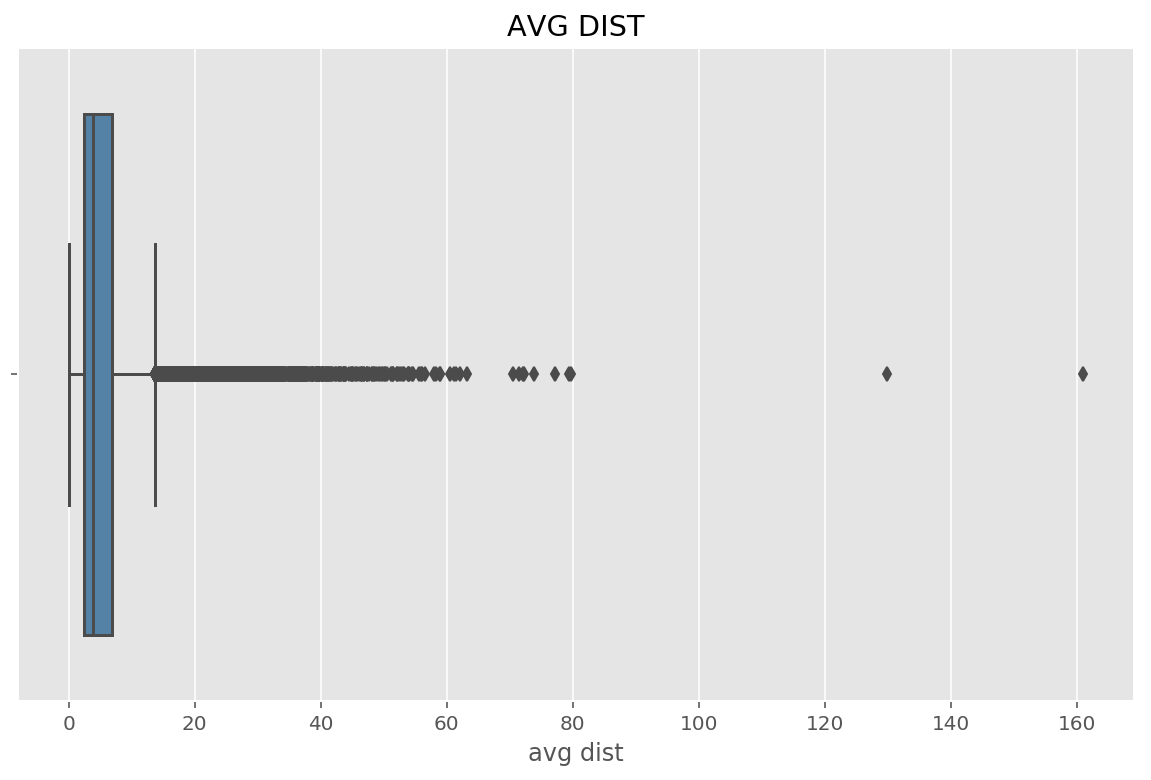

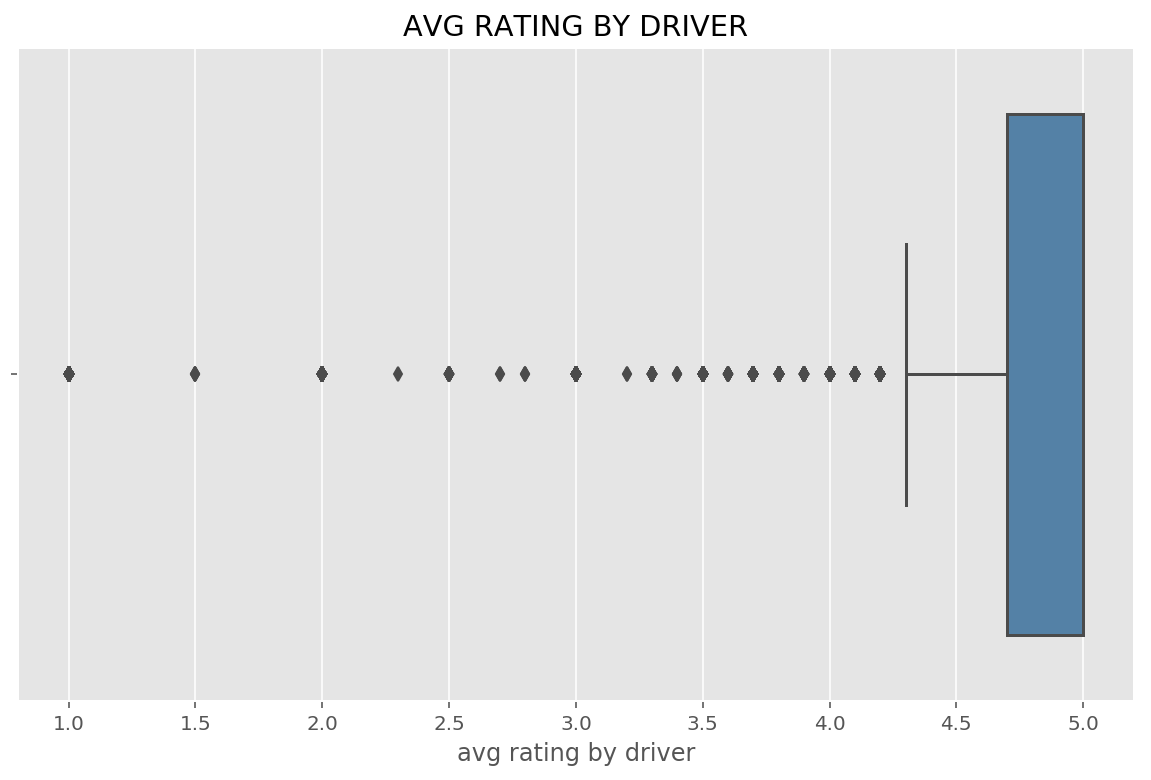

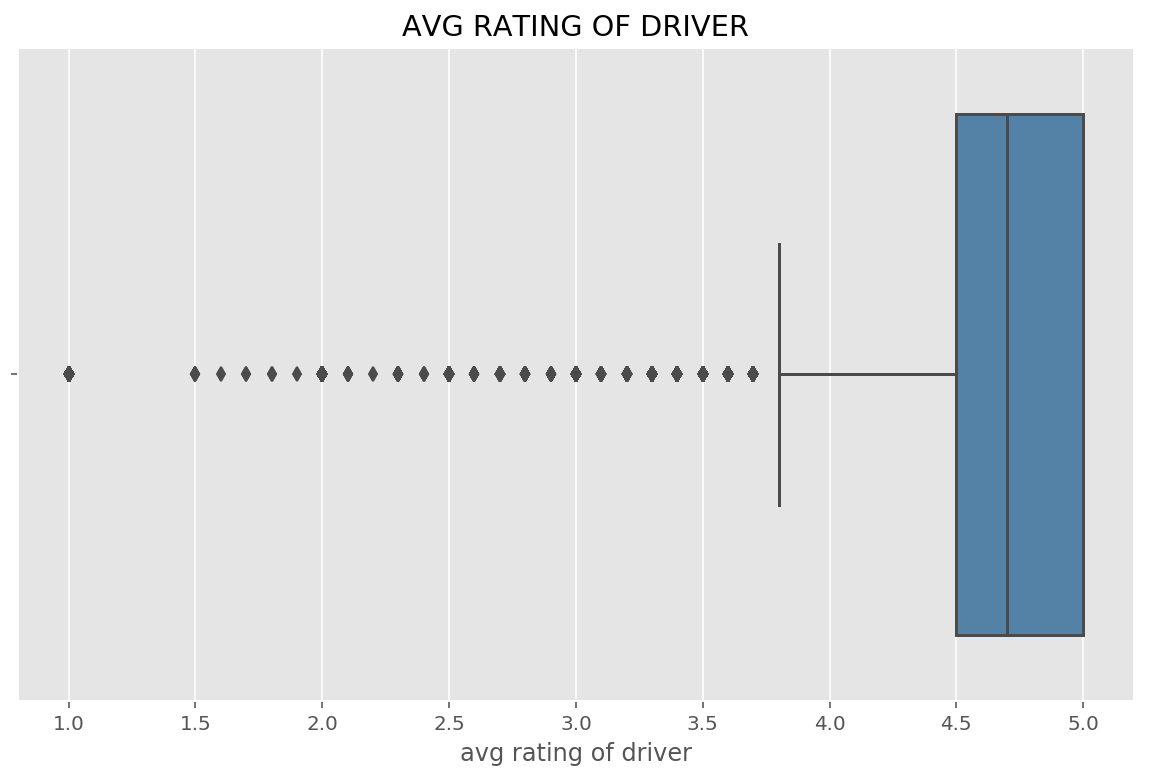

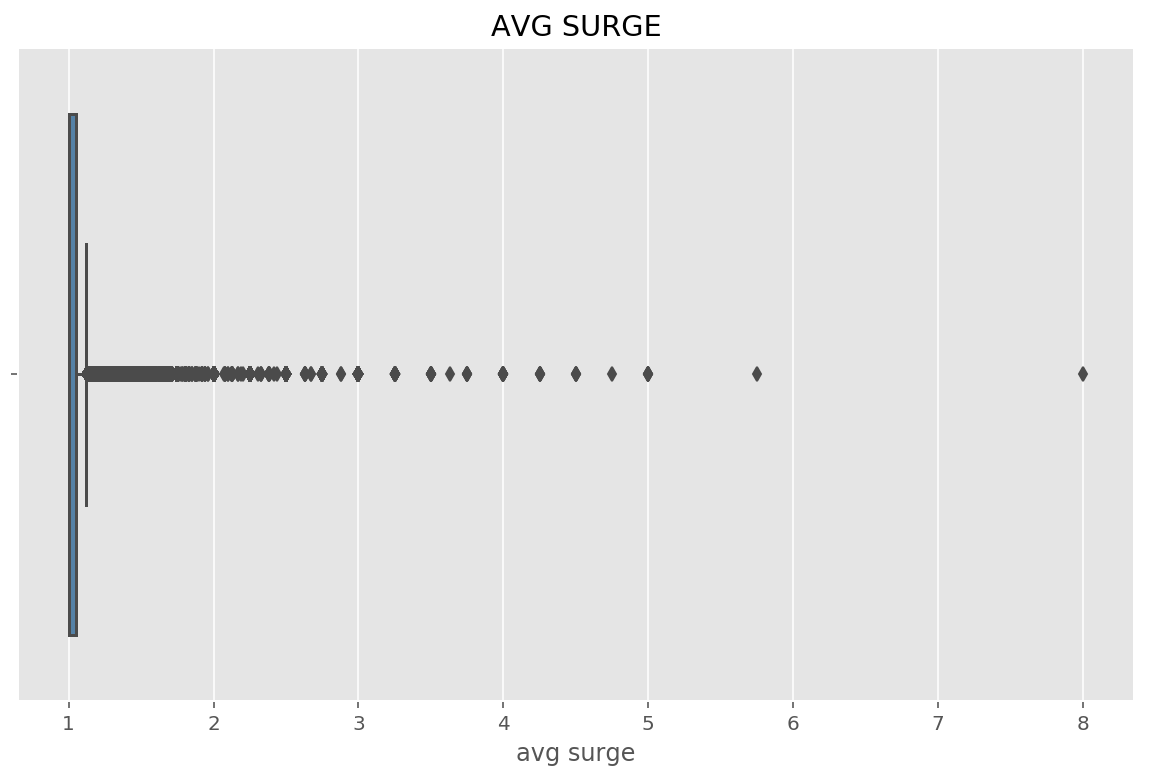

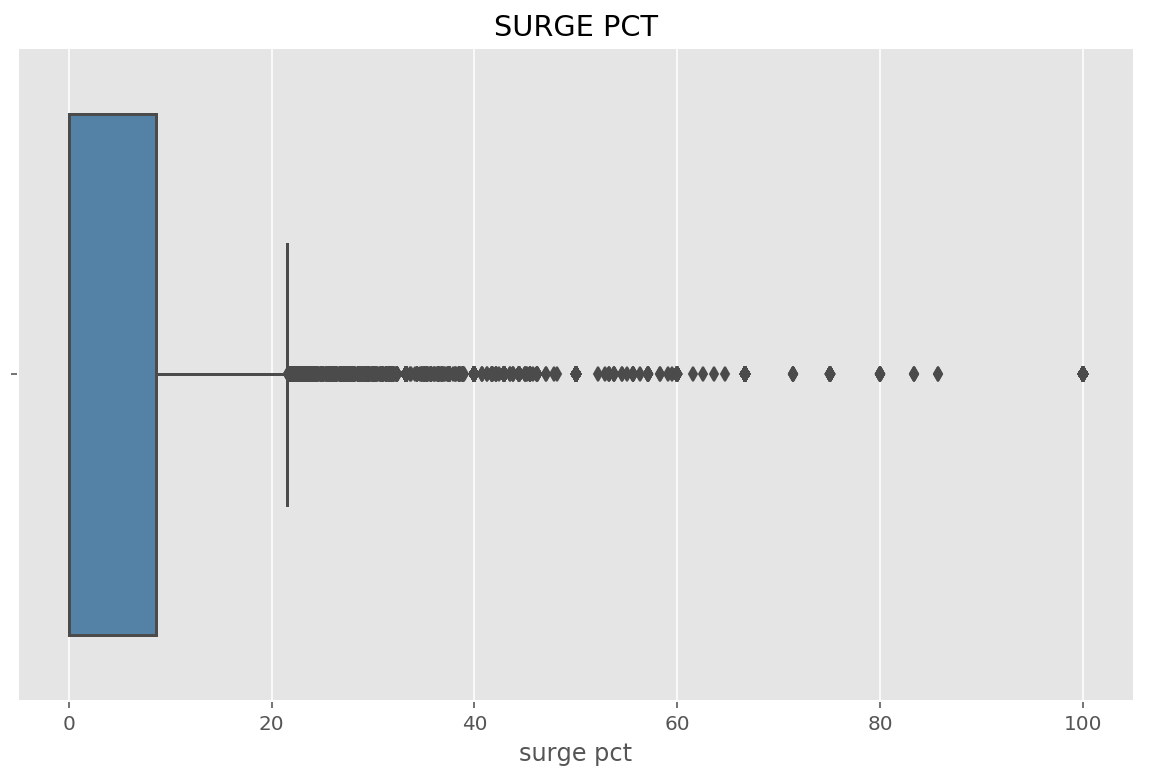

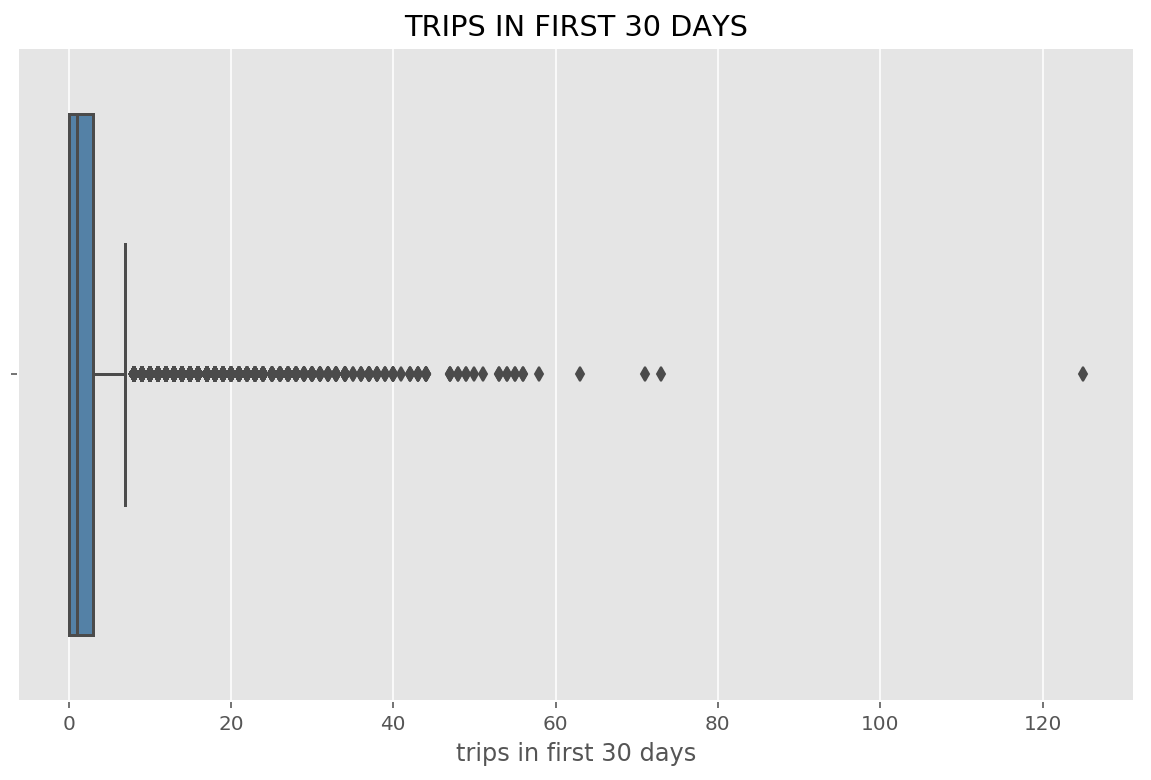

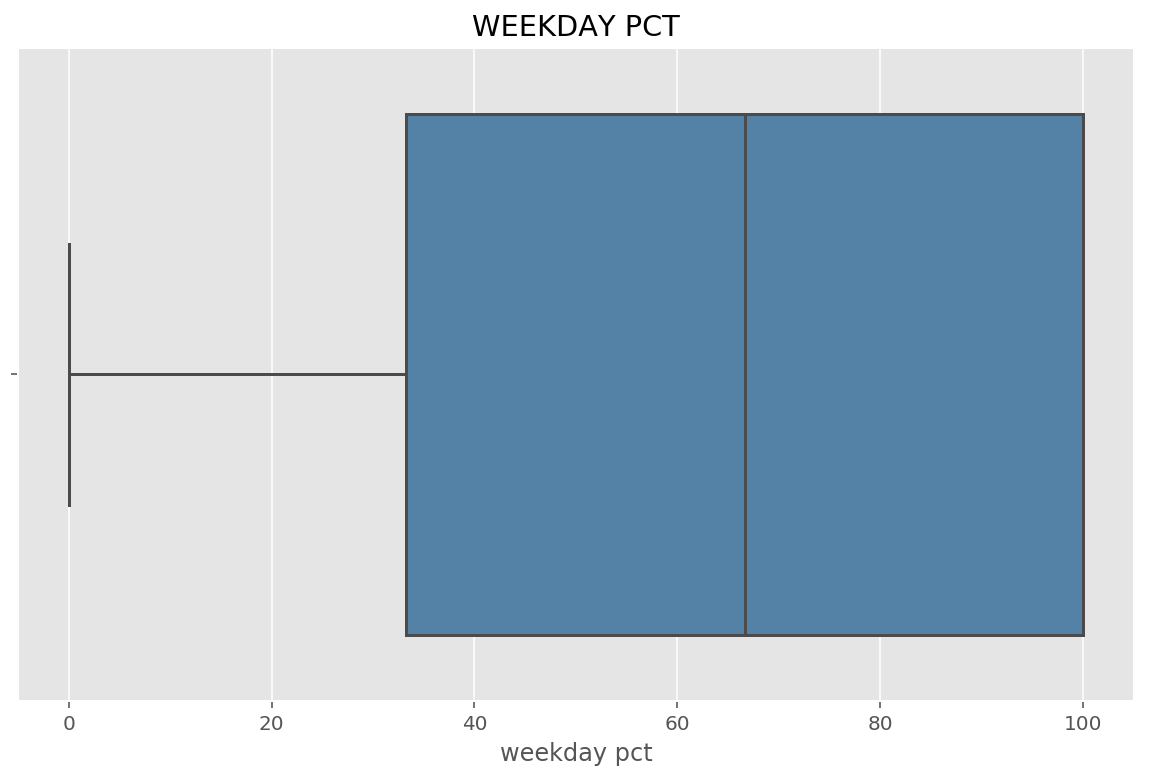

In [23]:
predict.boxplot(df, number_cols)

# _Observations_

We'll start by taking a look at the numeric columns and there is one thing very obvious from the boxplots above: outliers. The WWe need to address these before we go any further. 

There are a few methods that we can use to screen outliers, including (but not limited to):
- z-scores
- Grubb's test
- Tietjen-Moore test
- Inter-quartile 
- Tukey Method

The two methods I'll explore more in-depth is the z-score and inter-quartile methods. Below are the definitions for both such methods:

- Z-score: in simple terms, is the number of standard deviations from the mean a data point is
- Inter-quartile range: in simple terms, it is the middle 50% of the data (i.e. from the 25th percentile to the 75th percentile); further this method determines outliers as those that are 1.5 IQRs below the first quartile (i.e. 25th percentile) or 1.5 IQRs above the third quartile (i.e. 75th percentile)

Luckily it is pretty straightforward to implement these methods via `SciPy` and `NumPy`.

In [24]:
import scipy
import numpy as np

# _IQR_

In [25]:
# get the first and third quartiles, and IQR
q1 = df[number_cols].quantile(0.25)
q3 = df[number_cols].quantile(0.75)
iqr = q3 - q1
print(iqr)

avg_dist                   4.52
avg_rating_by_driver       0.30
avg_rating_of_driver       0.50
avg_surge                  0.05
surge_pct                  8.60
trips_in_first_30_days     3.00
weekday_pct               66.70
dtype: float64


In [26]:
# eliminate observations according to inter-quartile method
df_outlier = df[~((df[number_cols] < (q1 - 1.5 * iqr)) | (df[number_cols] > (q3 + 1.5 * iqr))).any(axis=1)]

In [27]:
df_outlier.shape

(29322, 12)

In [28]:
df.shape

(50000, 12)

# _Observations_

The inter-quartile method does not appear to be the best approach as it eliminates __a lot__ of our data. We want to preserve as much information as possible so we'll take a look at what the z-score method produces.

# _Z-Score_

In [29]:
z = np.abs(scipy.stats.zscore(df[number_cols]))
print(z)

[[3.72650244e-01 4.97683632e-01 1.74240305e-01 ... 3.28202393e-01
  4.53983824e-01 3.97131451e-01]
 [4.31582983e-01 4.97683632e-01 7.05241067e-01 ... 4.43394376e-01
  6.00688784e-01 2.94653460e-01]
 [8.80771455e-01 4.97683632e-01 5.33760712e-01 ... 4.43394376e-01
  1.90315672e-01 1.05374117e+00]
 ...
 [3.39359544e-01 4.97683632e-01 7.05241067e-01 ... 4.43394376e-01
  6.00688784e-01 1.05374117e+00]
 [2.13205312e-01 2.86744158e+00 2.83476401e+00 ... 4.43394376e-01
  7.33524799e-02 1.05374117e+00]
 [4.04188802e-01 4.97683632e-01 2.76685738e-13 ... 4.43394376e-01
  6.00688784e-01 1.64304809e+00]]


In [30]:
# use a z-score threshold of 3, i.e. if z-score is greater/less than 3, -3 that data point will be identified as an outlier
threshold = 3
print(np.where(z > 3))

(array([    4,    14,    16, ..., 49983, 49991, 49992]), array([5, 0, 1, ..., 2, 4, 2]))


# _Observations_

The first array above contains the list of row numbers and second array the respective column numbers of observations that have a z-score higher than 3.

In [31]:
df_zscore = df[(z < 3).all(axis=1)]

In [32]:
df_zscore.shape

(44698, 12)

In [33]:
df.shape[0] - df_zscore.shape[0]

5302

# _Observations_ 

This looks a lot better as we only removed ~5300 observations versus nearly half with the inter-quartile method. Going forward we'll be using the `df_zscore` data set to dive further into the data and create a (hopefully) useful predictive model for rider retention.

In [34]:
df_zscore.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44698 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  44698 non-null float64
avg_rating_by_driver      44698 non-null float64
avg_rating_of_driver      44698 non-null float64
avg_surge                 44698 non-null float64
city                      44698 non-null category
last_trip_date            44698 non-null datetime64[ns]
phone                     44698 non-null category
signup_date               44698 non-null datetime64[ns]
surge_pct                 44698 non-null float64
trips_in_first_30_days    44698 non-null int64
ultimate_black_user       44698 non-null bool
weekday_pct               44698 non-null float64
dtypes: bool(1), category(2), datetime64[ns](2), float64(6), int64(1)
memory usage: 3.5 MB


In [35]:
# let's check out the categorical features
categorical = ['city', 'phone', 'ultimate_black_user']

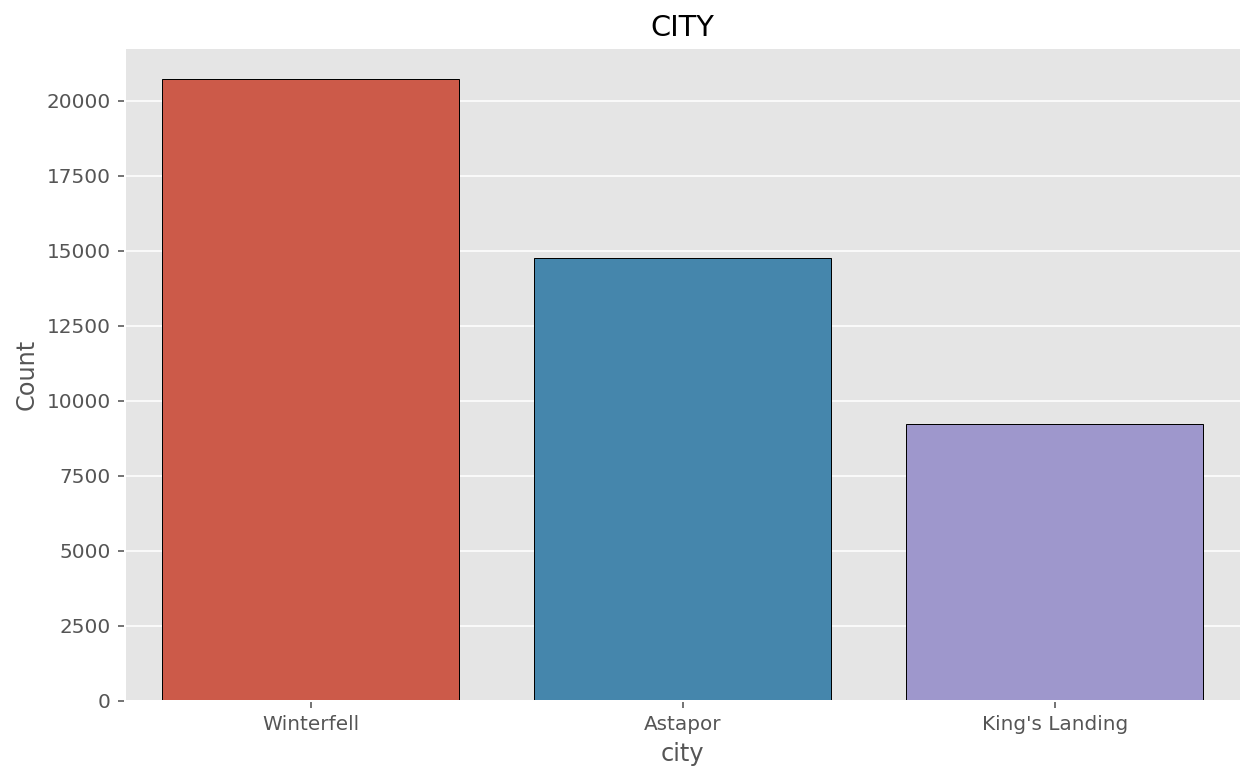

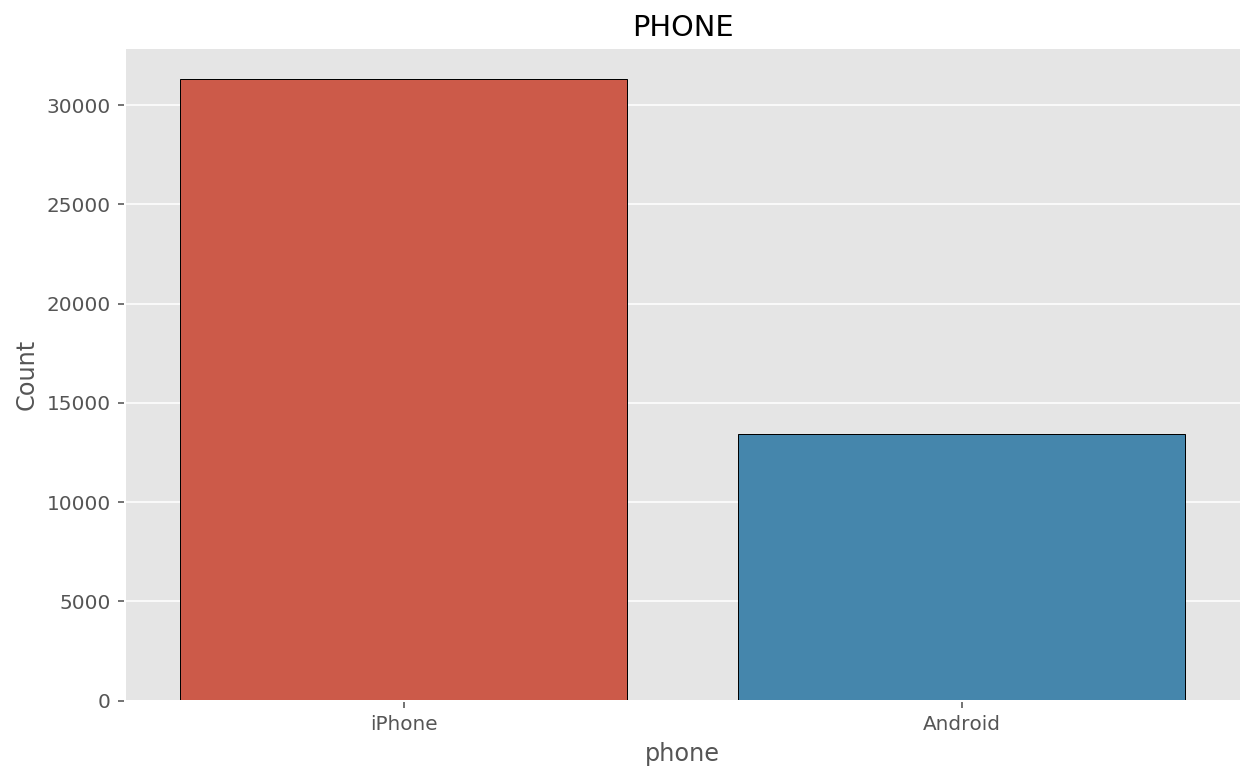

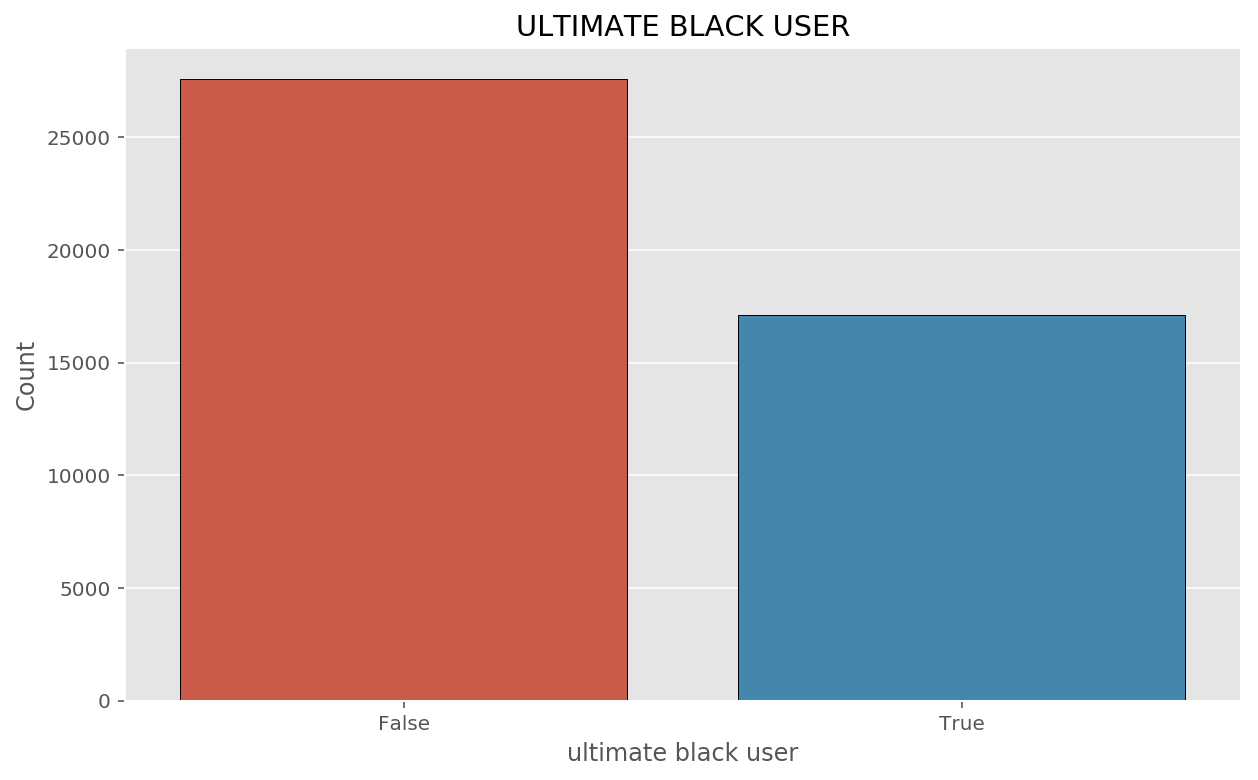

In [36]:
predict.barplot(df_zscore, categorical)

# _Observations_

By checking out our categorical features - city the user signed up in, OS of the user, and if the user took an Ultimate Black in their first 30 days - we can gain a few insights:

1. Winterfell had the most users and had quite a few more than Astapor and King's Landing, who were second and third, respectively. 
2. The majority of users utilized an iPhone.
3. Most people did __not__ take an Ultimate Black trip within their first 30 days. 

# _Predictive Modeling_

In [37]:
# get correlation matrix using the standard correlation coefficient
corr_matrix = df_zscore.corr(method='pearson')
corr_matrix

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
avg_dist,1.000000,0.112901,0.036682,-0.126167,-0.140392,-0.155967,0.033346,0.107226
avg_rating_by_driver,0.112901,1.000000,0.109088,-0.052971,-0.044393,-0.134042,-0.019620,0.020411
avg_rating_of_driver,0.036682,0.109088,1.000000,-0.029774,-0.012941,-0.058941,-0.010890,0.004768
avg_surge,-0.126167,-0.052971,-0.029774,1.000000,0.854540,0.146226,-0.022390,-0.093283
surge_pct,-0.140392,-0.044393,-0.012941,0.854540,1.000000,0.137750,-0.042008,-0.105270
trips_in_first_30_days,-0.155967,-0.134042,-0.058941,0.146226,0.137750,1.000000,0.081189,0.022686
ultimate_black_user,0.033346,-0.019620,-0.010890,-0.022390,-0.042008,0.081189,1.000000,0.022617
weekday_pct,0.107226,0.020411,0.004768,-0.093283,-0.105270,0.022686,0.022617,1.000000


In [38]:
# the above matrix is hard to discern, let's return correlations only for those variables that have strong (> 0.5) relationships
corr_matrix[(df_zscore.corr(method='pearson') > 0.5) | (df_zscore.corr(method='pearson') < -0.5)]

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
avg_dist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_rating_by_driver,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
avg_rating_of_driver,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
avg_surge,NaN,NaN,NaN,1.00000,0.85454,NaN,NaN,NaN
surge_pct,NaN,NaN,NaN,0.85454,1.00000,NaN,NaN,NaN
trips_in_first_30_days,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
ultimate_black_user,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
weekday_pct,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


# _Observations_

It looks like `surge_pct` and `avg_surge` are strongly correlated and intuitively this makes sense as both features have to do with surge. 

Now let's check out the last trip dates to get a better idea of the timeframe we're working with and whe the data was pulled. 

In [39]:
predict.trip_date_review(df_zscore, 'last_trip_date')

The first trip date was on 2014-01-01 00:00:00.
----------------------------------------
The most recent trip date was on 2014-07-01 00:00:00.
----------------------------------------
Here are the 5 most recent trips and their date times:
[Timestamp('2014-07-01 00:00:00'), Timestamp('2014-07-01 00:00:00'), Timestamp('2014-07-01 00:00:00'), Timestamp('2014-07-01 00:00:00'), Timestamp('2014-07-01 00:00:00')]
----------------------------------------
Below are the 5 most recent unique trips and their date times:
[numpy.datetime64('2014-07-01T00:00:00.000000000'), numpy.datetime64('2014-06-30T00:00:00.000000000'), numpy.datetime64('2014-06-29T00:00:00.000000000'), numpy.datetime64('2014-06-28T00:00:00.000000000'), numpy.datetime64('2014-06-27T00:00:00.000000000')]


In [40]:
# looks like the data was pulled on 07-01-2014, so we'll need to see how many users have taken a trip on or after 06-01-2014
predict.users_last30(df_zscore, 'last_trip_date', '2014-06-01')

38.49% of users have taken a trip since 2014-06-01.


# _Prep for Modeling_

In [41]:
df_model = predict.target_variable(df_zscore)
df_model.head()

Created retained_user column.
----------------------------------------
Assigned a value of 1 if user had used service since 2014-06-01 and 0 if they had not.
----------------------------------------
Dropped date time columns: last_trip_date and signup_date.
----------------------------------------
One-hot encoded categorical columns for Random Forest.


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,retained_user,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,3.67,5.0,4.7,1.10,15.4,4,46.2,1,0,1,0,0,1,0,1
1,8.26,5.0,5.0,1.00,0.0,0,50.0,0,1,0,0,1,0,1,0
2,0.77,5.0,4.3,1.00,0.0,3,100.0,0,1,0,0,0,1,1,0
3,2.36,4.9,4.6,1.14,20.0,9,80.0,1,0,1,0,0,1,0,1
5,10.56,5.0,3.5,1.00,0.0,2,100.0,1,0,0,1,0,1,0,1


In [42]:
print('{}% of observations have a value of 1 in {} column.'.format(round(df_model['retained_user'].sum() 
                                                                        / len(df_model) * 100, 2), 
                                                                  'retained_user'))

38.49% of observations have a value of 1 in retained_user column.


# _Observations_

Looks like we're good to go! We have our target column - `retained_user` - which indicates if the user had taken a ride within the last days (i.e. 1) or not (i.e. 0). Now we're ready to start with the machine learning portion of this challenge!

The problem we are trying to solve has to do with classification - we're trying to classify rider retention, either a rider has stayed 'active' or has stopped using the service. For this purpose, we'll be using a random forest classifier. This is an ensemble learning method, which in a way is similar to the 'wisdom of the crowd' concept. 

Random forest consists of an ensemble (a group) of decision trees, each with their own prediction. Whichever class ends up with the most votes becomes the model's prediction.

Now why not just use a decision tree then?

Simple: a large number of relatively uncorrelated models (i.e. decision trees) operating as a committee will outperform any of the individual constituent models. ([Source](https://towardsdatascience.com/understanding-random-forest-58381e0602d2))

Plus, we'll have the added benefit of being able to use all the features within our dataset. 

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, roc_auc_score
from matplotlib import pyplot

## _Baseline Model_

We're going to create a baseline Random Forest Model to see initial results, then we'll fine-tune to try and improve results (if necessary).

In [133]:
X = df_model.drop('retained_user', axis=1)
y = df_model['retained_user']

Mean ROC-AUC score of test set for Baseline Random Forest: 0.816
Mean Precision score of test set for Baseline Random Forest: 0.679
Mean Recall score of test set for Baseline Random Forest: 0.660


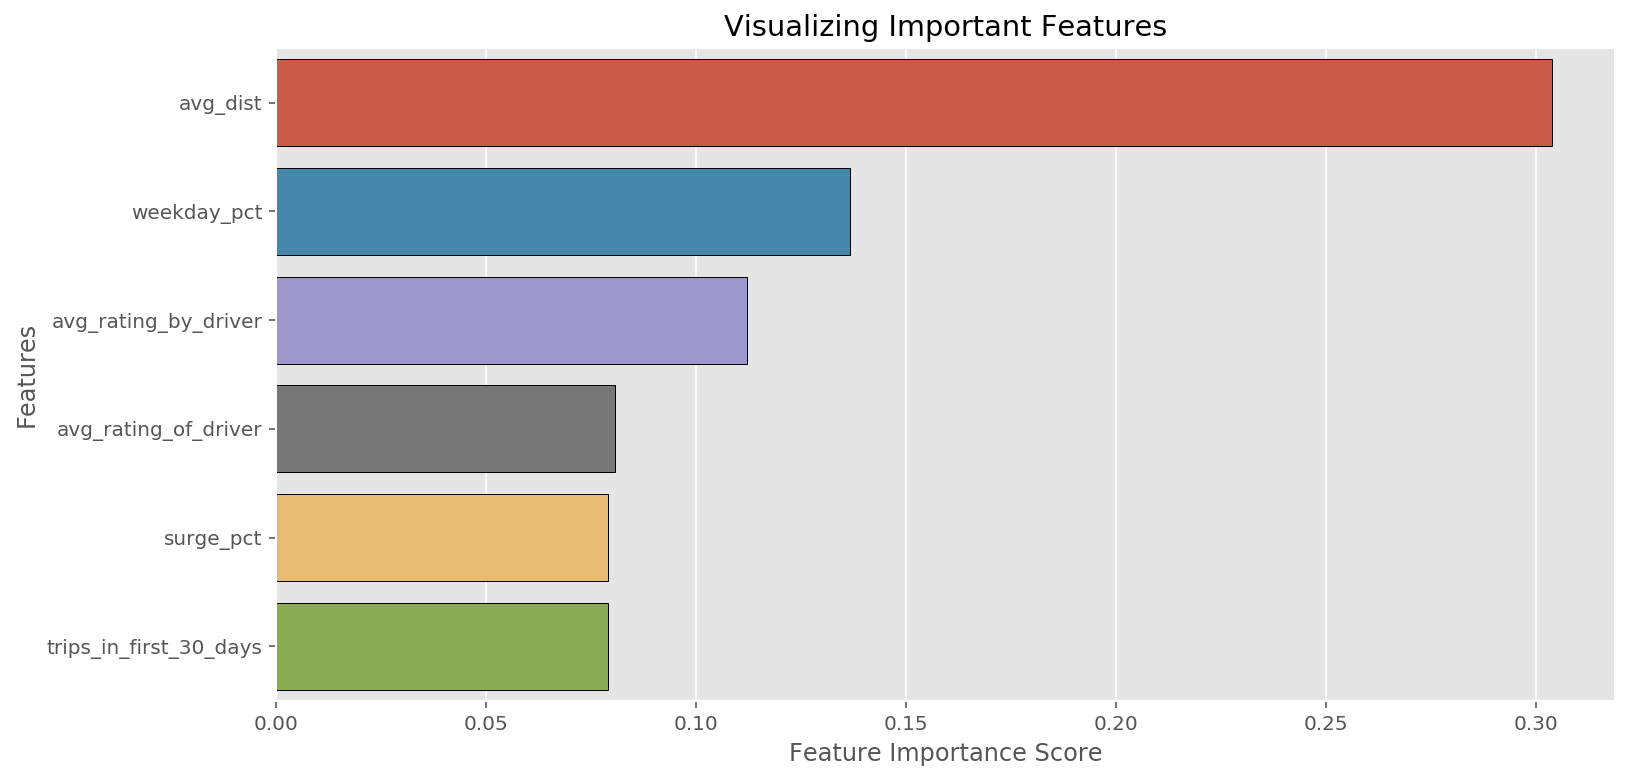

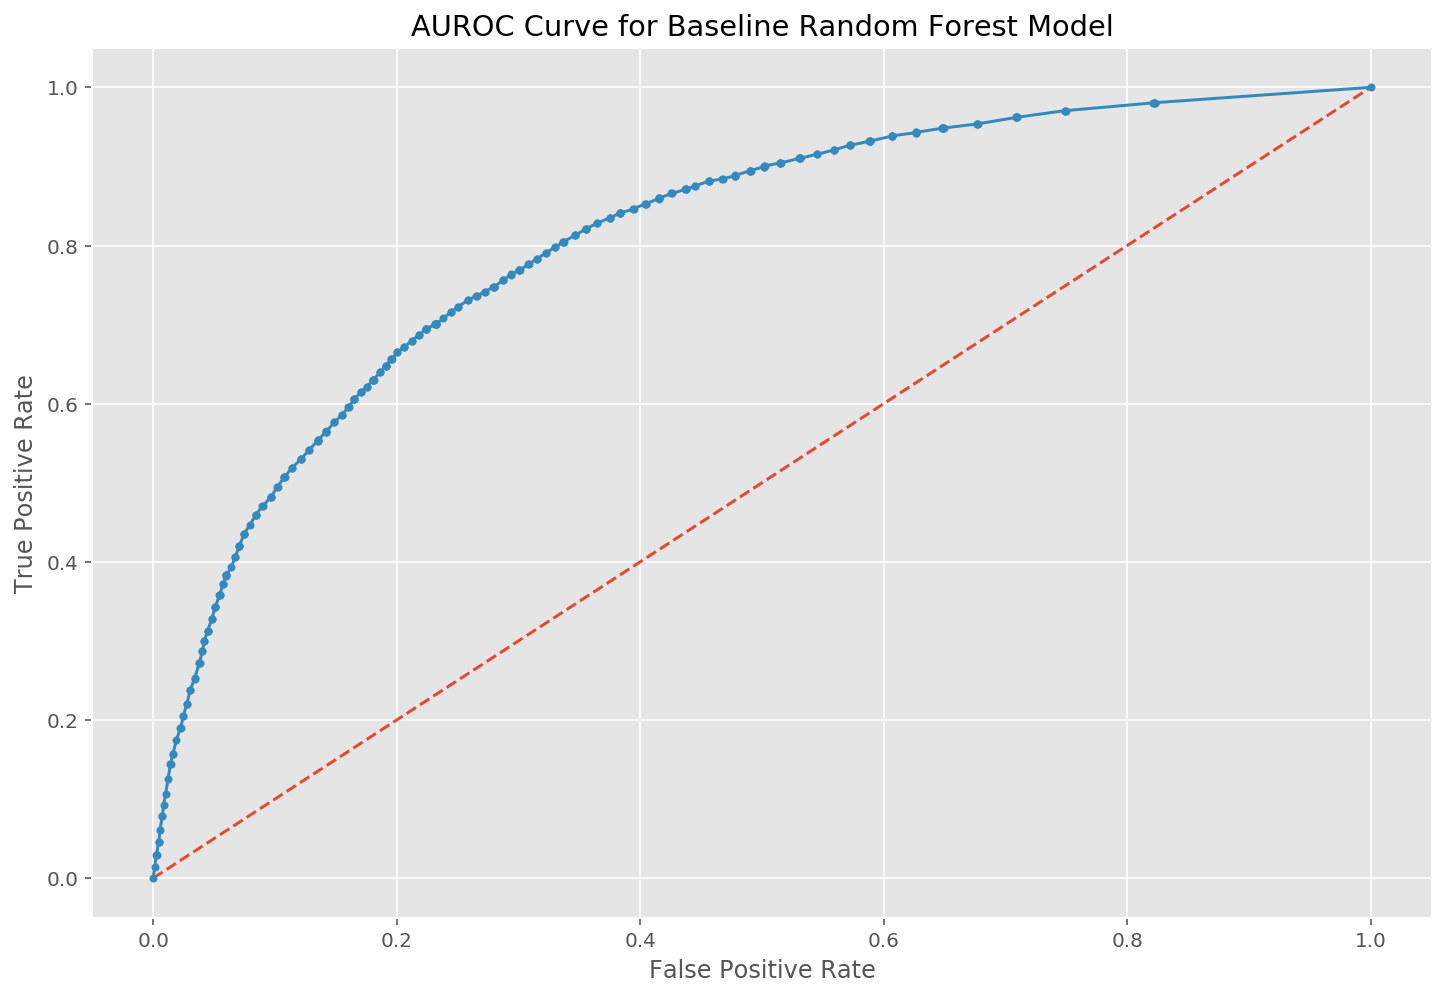

In [134]:
baseline_rf, baseline_scores = predict.ml_baseline(X, y, random_state=1, title='Baseline Random Forest');

In [141]:
baseline_scores

{'fit_time': array([2.72129011, 2.69796085, 2.70057678, 2.75415015, 0.93058205]),
 'score_time': array([0.48920107, 0.74799418, 0.77605033, 0.71929479, 0.42568183]),
 'test_roc_auc': array([0.81090385, 0.82035242, 0.81908795, 0.81634926, 0.81574946]),
 'test_precision': array([0.6750319 , 0.69282211, 0.67351215, 0.67442845, 0.6812766 ]),
 'test_recall': array([0.659601  , 0.64588529, 0.66791355, 0.66209476, 0.66541978]),
 'test_accuracy': array([0.74704378, 0.75375519, 0.74784276, 0.74716318, 0.75163817])}

# _Observations_

Our baseline model does a pretty good job according to the ROC-AUC metric, which is equal to 0.816. Essentially what this metric tells us is how good the model is at distinguishing between classes. The perfect score would be 1.0, and the curved blue line would go straight up to 1.0 and then straight over to (1, 1) and intersect with the red line. Another way to look at is that for classification problems, you want to maximize the area underneath the curved blue line. 

With this knowledge in hand let's see if we can fine-tune this model to make it even better!

For this we will use Scikit-Learn's `RandomizedSearchCV` method, which will randomly test a combination of hyperparameters (which we'll define before) with cross-validation to give us the best model possible. Even though not all combinations will be used (which we could do via `GridSearchCV`) we're going to save quite a bit of time with only a minimal hit on performance. 

In [135]:
from pprint import pprint

print('Parameters currently in use:\n')
pprint(baseline_rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}


So this list can be quite overwheling. However, some of these hyperparameters are more important than others. Here are the ones we'll be tuning first (i.e. their more important):

- `n_estimators`: number of decision trees in the forest
- `max_features`: number of features from the data considered for splitting at a node
- `max_depth`: number of levels in each decision tree
- `min_samples_split`: number of data points placed in a node before node is split
- `min_samples_leaf`: number of data points allowed in a leaf node
- `bootstrap`: method for sampling data points (with/without replacement)

In [136]:
# create base model to tune
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=1)

In [137]:
random_grid = predict.gridsearch_params()
random_grid

{'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [138]:
n_estimators, min_split, min_leaf, max_features, max_depth, bootstrap = predict.randomizedsearchCV(estimator=rf, 
                                                                                                   X=X, y=y, n_iter_search=100, 
                                                                                                   param_distributions=random_grid, 
                                                                                                   random_state=1);

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.4min finished


RandomizedSearchCV took 264.09 seconds for 100 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.845 (std: 0.004)
Parameters: {'n_estimators': 70, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}

Model with rank: 2
Mean validation score: 0.845 (std: 0.004)
Parameters: {'n_estimators': 90, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}

Model with rank: 3
Mean validation score: 0.845 (std: 0.004)
Parameters: {'n_estimators': 40, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': False}



Mean ROC-AUC score of test set for Random Forest with Best Parameters: 0.845
Mean Precision score of test set for Random Forest with Best Parameters: 0.739
Mean Recall score of test set for Random Forest with Best Parameters: 0.646


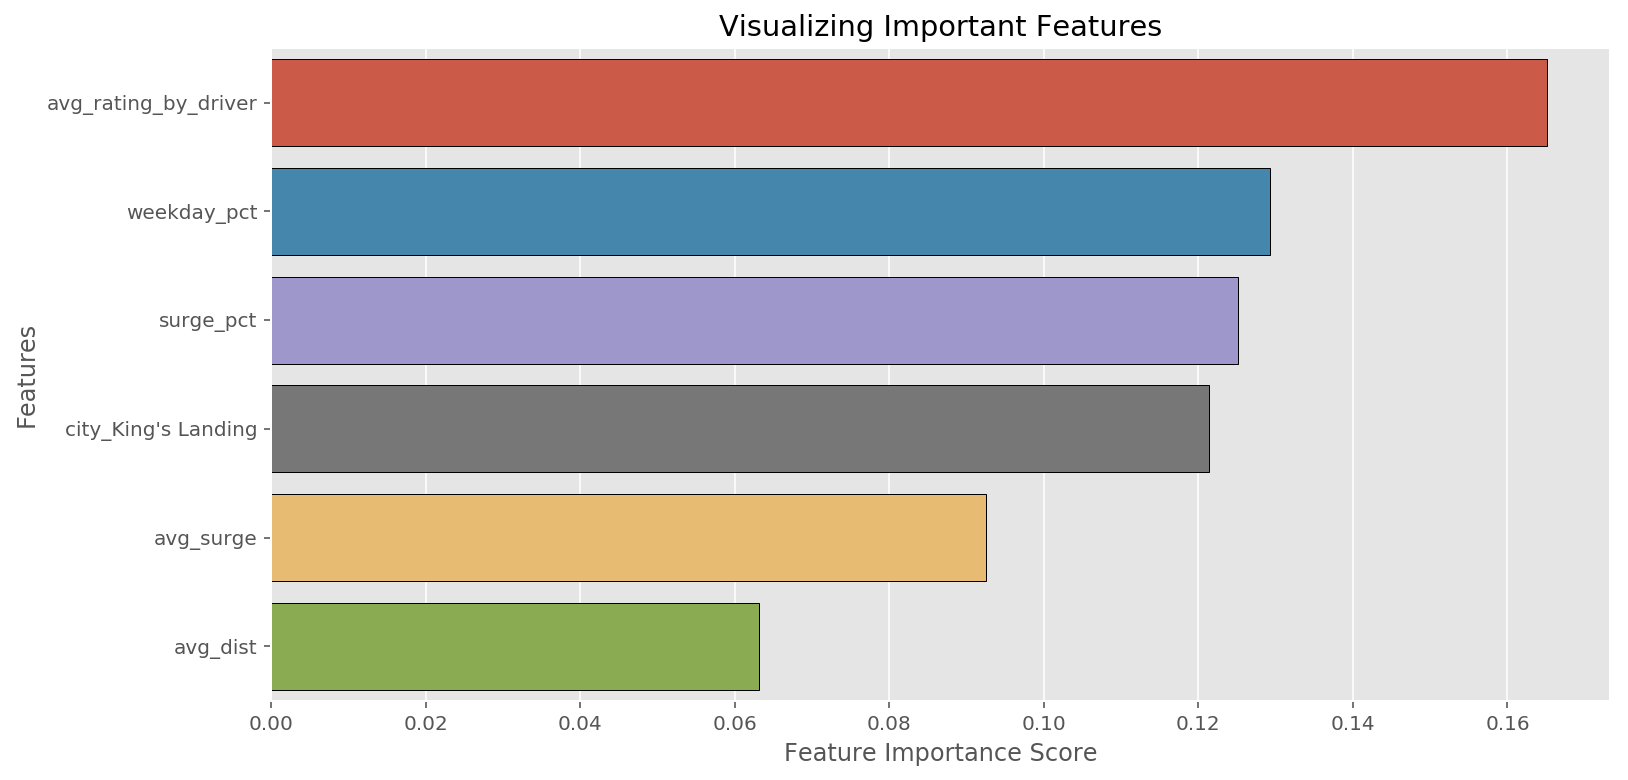

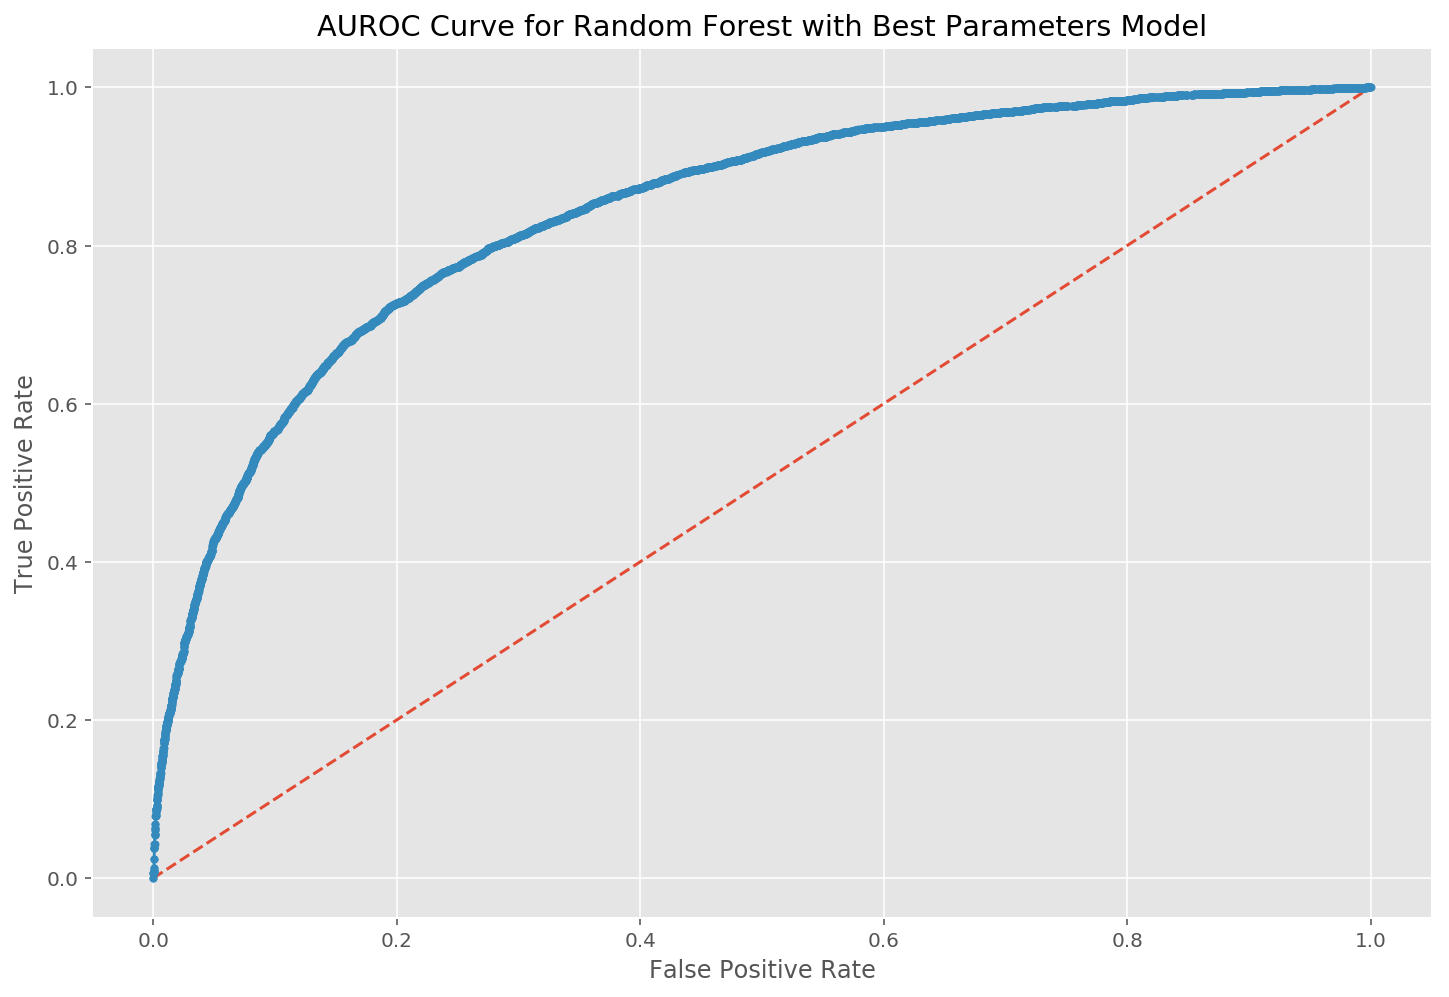

In [139]:
bestparams_rf, bestparam_scores = predict.ml_bestparams(X, y, random_state=1, n_estimators=n_estimators, 
                                                        min_samples_split=min_split, min_samples_leaf=min_leaf,
                                                        max_features=max_features, max_depth=max_depth, bootstrap=True, 
                                                        title='Random Forest with Best Parameters')

In [140]:
bestparam_scores

{'fit_time': array([0.89589977, 0.94712591, 0.85199475, 0.85714507, 0.33474088]),
 'score_time': array([0.43656707, 0.42203212, 0.43357635, 0.44008589, 0.43423223]),
 'test_roc_auc': array([0.84056371, 0.85026368, 0.84650027, 0.84547093, 0.84051659]),
 'test_precision': array([0.72684752, 0.75099602, 0.73473193, 0.74679335, 0.73486626]),
 'test_recall': array([0.64588529, 0.62676642, 0.65502909, 0.65336658, 0.65087282]),
 'test_accuracy': array([0.77053372, 0.77660594, 0.77644615, 0.78152469, 0.77545149])}

# _Observations_

We were able to slightly increase the performance of this model based on ROC-AUC (and accuracy). More importantly we were able to get better insights into some of the features that could be of use to Ultimate in regards to retaining riders.

1. `avg_rating_by_driver`: This indicates that the rider's rating has the most significant impact on how often they ride. There could be a few reasons for this. One, riders with lower scores don't want to be picked up by drivers and thus do not ride often. Alternatively, individuals with higher scores could be biased in that they do not ride that often but when they have received rides they received higher scores. Taking more rides, and thus receiving more ratings, is likely to push down this number even if they are a 'good' rider. 
2. `weekday_pct`: This could indicate that riders who get a higher percentage of their rides on weekdays tend to be retained. This makes sense in that these individuals could be utilizing the service as their main means of transportation, and thus are more likely to use the service compared to someone who only uses it on the weekends.
3. `surge_pct`: This could indicate that when there is a higher surge, it could impact whether or not an individual decides to get a ride. In theory, this could also be connected to weekend riders. From the EDA, late night hours tended to be high volume and one can imagine this being largely attributable to the weekends; the weekend riders may be discouraged from using the service (or use a competitor's) based on this increased volume that is reflected in the surge pricing. 